# **Big mart sales prediction** #

## **Importing necessary libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_val_score
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"]=(8,5)
plt.rcParams["font.size"]=10

### **Reading Train and Test data sets**

---



In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/big-mart-sales-prediction/Submission.csv
/kaggle/input/big-mart-sales-prediction/Train.csv
/kaggle/input/big-mart-sales-prediction/Test.csv


In [3]:
train=pd.read_csv("../input/big-mart-sales-prediction/Train.csv")
test=pd.read_csv("../input/big-mart-sales-prediction/Test.csv")
train.shape,test.shape

((8523, 12), (5681, 11))

**Concatenate both data sets into one to preprocess at once**

In [4]:
sales=pd.concat([train,test],ignore_index=True)
sales.shape

(14204, 12)

## **Data Exploration**

In [5]:
sales.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [6]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14204 entries, 0 to 14203
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            14204 non-null  object 
 1   Item_Weight                11765 non-null  float64
 2   Item_Fat_Content           14204 non-null  object 
 3   Item_Visibility            14204 non-null  float64
 4   Item_Type                  14204 non-null  object 
 5   Item_MRP                   14204 non-null  float64
 6   Outlet_Identifier          14204 non-null  object 
 7   Outlet_Establishment_Year  14204 non-null  int64  
 8   Outlet_Size                10188 non-null  object 
 9   Outlet_Location_Type       14204 non-null  object 
 10  Outlet_Type                14204 non-null  object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 1.3+ MB


In [7]:
# statistics of numerical data
sales.describe().T

,count,mean,std,min,25%,50%,75%,max
Item_Weight,11765.0,12.792854,4.652502,4.555,8.710000,12.600000,16.750000,21.350000
Item_Visibility,14204.0,0.065953,0.051459,0.000,0.027036,0.054021,0.094037,0.328391
Item_MRP,14204.0,141.004977,62.086938,31.290,94.012000,142.247000,185.855600,266.888400
Outlet_Establishment_Year,14204.0,1997.830681,8.371664,1985.000,1987.000000,1999.000000,2004.000000,2009.000000
Item_Outlet_Sales,8523.0,2181.288914,1706.499616,33.290,834.247400,1794.331000,3101.296400,13086.964800


In [8]:
sales.isna().sum()

Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
dtype: int64


               missing values are present in 'Item_Weight' and 'Outlet_Size'. 
               Ignore missing values in 'Item_Outlet_Sales'


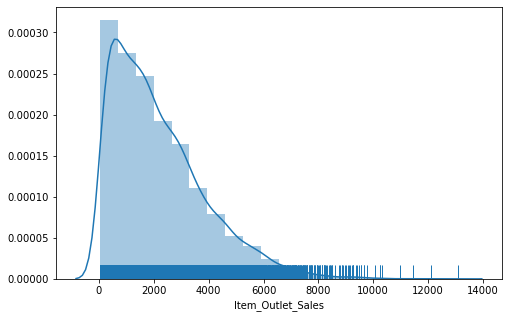

In [9]:
# Distribution of target values
sns.distplot(sales['Item_Outlet_Sales'],bins=20,rug=True,hist=True)
plt.show()

In [10]:
sales.Item_Outlet_Sales.mean()

2181.2889135750365

## **Categorical data**

In [11]:
sales['Outlet_Size'].unique()

array(['Medium', nan, 'High', 'Small'], dtype=object)

In [12]:
sales['Outlet_Identifier'].unique()


array(['OUT049', 'OUT018', 'OUT010', 'OUT013', 'OUT027', 'OUT045',
       'OUT017', 'OUT046', 'OUT035', 'OUT019'], dtype=object)

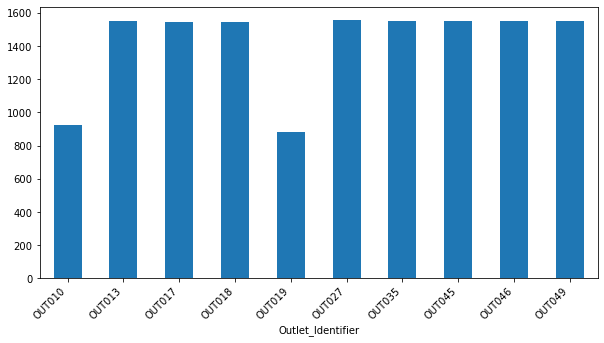

In [13]:
# OUTLET IDENTIFIER CATEGORIES
plt.figure(figsize=(10,5))
sales.groupby(['Outlet_Identifier']).size().plot(kind='bar')
plt.xticks(rotation=45,horizontalalignment='right')
plt.show()

In [14]:
sales['Item_Type'].unique()

array(['Dairy', 'Soft Drinks', 'Meat', 'Fruits and Vegetables',
       'Household', 'Baking Goods', 'Snack Foods', 'Frozen Foods',
       'Breakfast', 'Health and Hygiene', 'Hard Drinks', 'Canned',
       'Breads', 'Starchy Foods', 'Others', 'Seafood'], dtype=object)

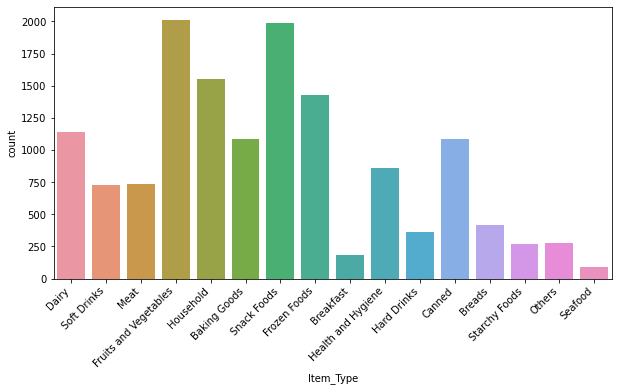

In [15]:
# DIFFERENT ITEM TYPES PRESENT IN THE RETAIL STORE
plt.figure(figsize=(10,5))
sns.countplot('Item_Type',data=sales)
plt.xticks(rotation=45,horizontalalignment='right')
plt.show()

In [16]:
sales['Outlet_Type'].unique()

array(['Supermarket Type1', 'Supermarket Type2', 'Grocery Store',
       'Supermarket Type3'], dtype=object)

In [17]:
np.sort(sales['Outlet_Establishment_Year'].unique())

array([1985, 1987, 1997, 1998, 1999, 2002, 2004, 2007, 2009])

In [18]:
sales['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

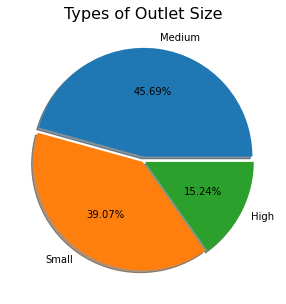

In [19]:
#PROPORTION OF DIFFERENT TYPES OF OUTLET SIZES
plt.figure(figsize=(5,5))
plt.pie(x=sales['Outlet_Size'].value_counts(),
        labels=["Medium","Small",'High'],
        autopct='%1.2f%%',
        explode=[0.04,0.01,0.02],shadow=True,)

plt.title("Types of Outlet Size",fontsize=16)
plt.show()

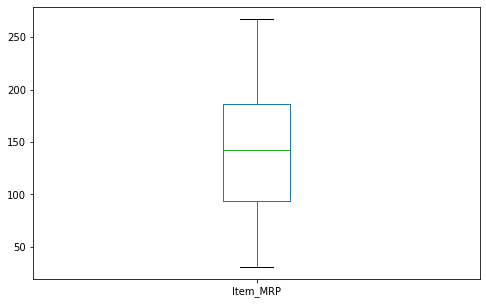

In [20]:
sales['Item_MRP'].plot(kind='box')
# no outliers present in Item_MRP

### **b. Bivariate Analysis**

In [21]:
plot_fig =sales.groupby('Outlet_Type').agg({'Item_Outlet_Sales':'mean'}).sort_values(by='Item_Outlet_Sales',ascending=False).reset_index()
plot_fig

,Outlet_Type,Item_Outlet_Sales
0,Supermarket Type3,3694.038558
1,Supermarket Type1,2316.181148
2,Supermarket Type2,1995.498739
3,Grocery Store,339.828500


In [22]:
plt.figure(figsize=(5,3))
fig=px.pie(plot_fig,names='Item_Outlet_Sales',values='Outlet_Type')
fig.show()

<Figure size 360x216 with 0 Axes>

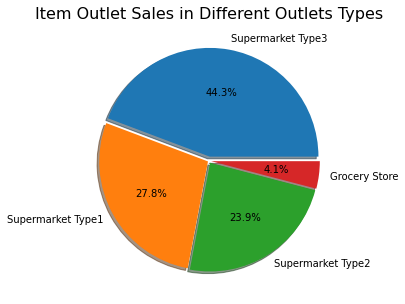

In [23]:
plt.pie(x=plot_fig['Item_Outlet_Sales'],
        labels=plot_fig['Outlet_Type'],
        autopct='%1.1f%%',
        explode=[0.04,0.01,0.02,0.02],shadow=True)
plt.title("Item Outlet Sales in Different Outlets Types",fontsize=16)
plt.show()

In [24]:
#checking relation between establishment year with outlet type
sales.groupby(['Outlet_Establishment_Year','Outlet_Type']).size()  

Outlet_Establishment_Year  Outlet_Type      
1985                       Grocery Store         880
                           Supermarket Type3    1559
1987                       Supermarket Type1    1553
1997                       Supermarket Type1    1550
1998                       Grocery Store         925
1999                       Supermarket Type1    1550
2002                       Supermarket Type1    1548
2004                       Supermarket Type1    1550
2007                       Supermarket Type1    1543
2009                       Supermarket Type2    1546
dtype: int64

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

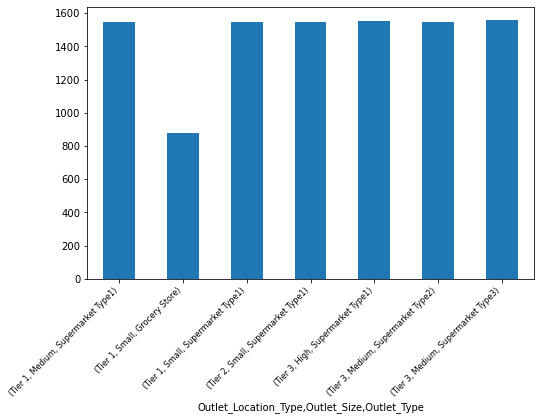

In [25]:
sales.groupby(['Outlet_Location_Type','Outlet_Size','Outlet_Type']).size().plot(kind='bar')
plt.xticks(rotation=45,horizontalalignment='right',fontsize=8)

In [26]:
sales[(sales['Outlet_Type']=='Supermarket Type1') & (sales['Outlet_Location_Type']=='Tier 1')]['Outlet_Size'].value_counts()
#supermarket type 1 and tier 1 have small and high outlet size

Small     1550
Medium    1550
Name: Outlet_Size, dtype: int64

In [27]:
sales.groupby(['Outlet_Size','Outlet_Location_Type']).size()

Outlet_Size  Outlet_Location_Type
High         Tier 3                  1553
Medium       Tier 1                  1550
             Tier 3                  3105
Small        Tier 1                  2430
             Tier 2                  1550
dtype: int64

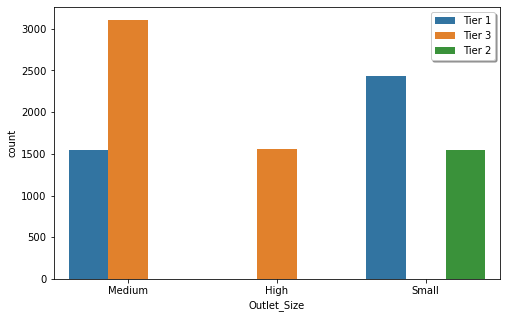

In [28]:
# visualizing the above groupby command individually
sns.countplot('Outlet_Size',hue='Outlet_Location_Type',data=sales)
plt.legend(loc="upper right",shadow=True,fancybox=True)

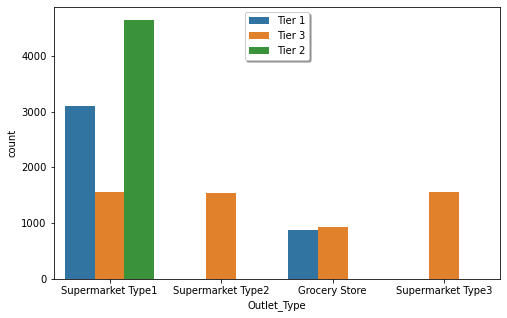

In [29]:
sns.countplot("Outlet_Type",hue='Outlet_Location_Type',data=sales)
plt.legend(loc="upper center",shadow=True,fancybox=True)
plt.show()

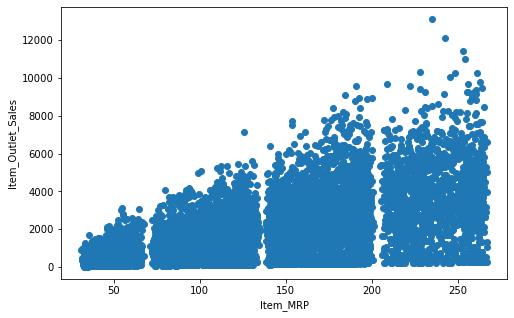

In [30]:
# SCATTER PLOT OF TARGET VARIABLE WITH ITEM MRP
plt.scatter(sales['Item_MRP'],sales['Item_Outlet_Sales'])
plt.xlabel("Item_MRP")
plt.ylabel("Item_Outlet_Sales")
plt.show()

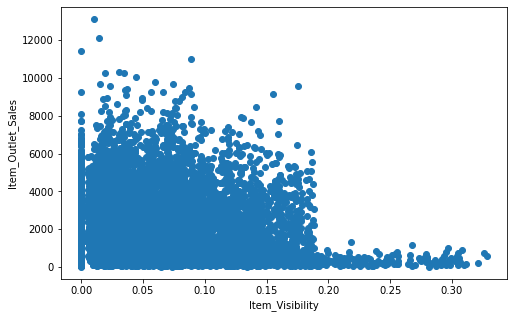

In [31]:
plt.scatter(sales['Item_Visibility'],sales['Item_Outlet_Sales'])
plt.xlabel("Item_Visibility")
plt.ylabel("Item_Outlet_Sales")
plt.show()

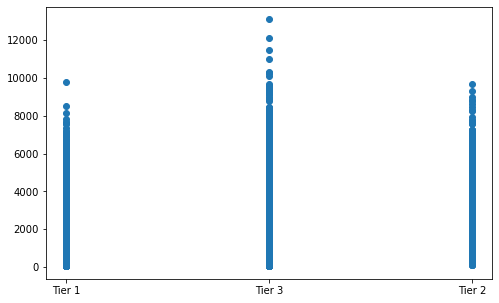

In [32]:
plt.scatter(sales['Outlet_Location_Type'],sales['Item_Outlet_Sales'])

In [33]:
sales[sales['Outlet_Location_Type']=='Tier 2']
# tier 2 has only small and nan values

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
8,FDH17,16.200,Regular,0.016687,Frozen Foods,96.9726,OUT045,2002,NaN,Tier 2,Supermarket Type1,1076.5986
9,FDU28,19.200,Regular,0.094450,Frozen Foods,187.8214,OUT017,2007,NaN,Tier 2,Supermarket Type1,4710.5350
19,FDU02,13.350,Low Fat,0.102492,Dairy,230.5352,OUT035,2004,Small,Tier 2,Supermarket Type1,2748.4224
22,NCB30,14.600,Low Fat,0.025698,Household,196.5084,OUT035,2004,Small,Tier 2,Supermarket Type1,1587.2672
25,NCD06,13.000,Low Fat,0.099887,Household,45.9060,OUT017,2007,NaN,Tier 2,Supermarket Type1,838.9080
...,...,...,...,...,...,...,...,...,...,...,...,...
14185,FDK22,9.800,Low Fat,0.026234,Snack Foods,214.3850,OUT017,2007,NaN,Tier 2,Supermarket Type1,NaN
14193,FDO03,10.395,Regular,0.037092,Meat,229.4352,OUT017,2007,NaN,Tier 2,Supermarket Type1,NaN
14201,NCO17,10.000,Low Fat,0.073529,Health and Hygiene,118.7440,OUT045,2002,NaN,Tier 2,Supermarket Type1,NaN
14202,FDJ26,15.300,Regular,0.000000,Canned,214.6218,OUT017,2007,NaN,Tier 2,Supermarket Type1,NaN


In [34]:
sales[(sales['Outlet_Type']=='Grocery Store') & (sales['Outlet_Location_Type']=='Tier 1')]['Outlet_Size'].unique()
#small outlet_size is present only where location is Tier 2 and type is grocery

array(['Small'], dtype=object)

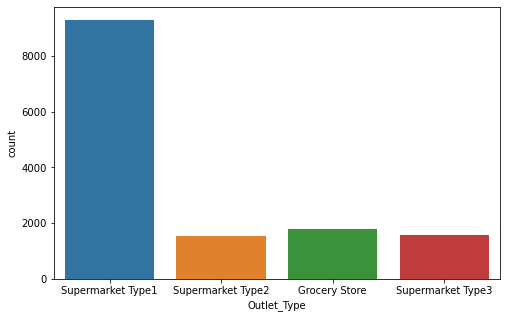

In [35]:
# OUTLET TYPE CATEGORIES
sns.countplot('Outlet_Type',data=sales)

In [36]:
pd.crosstab(sales["Outlet_Size"],sales["Outlet_Type"])

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,,,,
High,0,1553,0,0
Medium,0,1550,1546,1559
Small,880,3100,0,0


In [37]:
pd.crosstab(sales["Outlet_Size"],sales["Outlet_Location_Type"])

Outlet_Location_Type,Tier 1,Tier 2,Tier 3
Outlet_Size,,,
High,0,0,1553
Medium,1550,0,3105
Small,2430,1550,0


Inference from above crosstabs--> 'Small' is present only in grocery and Tier 2.


1.   Impute small as outlet type where type is Grocery.
2.   Impute small as outlet type where location is Tier 2.




In [38]:
sales.loc[sales['Outlet_Type']=='Grocery Store','Outlet_Size']='Small'

In [39]:
sales.loc[sales['Outlet_Location_Type']=='Tier 2','Outlet_Size']='Small'

In [40]:
sales['Outlet_Size'].isna().sum()
# now no missing values are there

0

(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

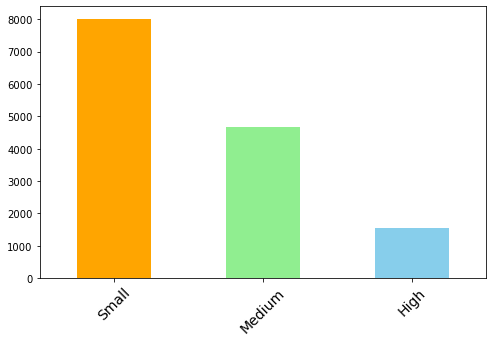

In [41]:
sales['Outlet_Size'].value_counts().plot(kind='bar',color=['orange','lightgreen','skyblue'])
plt.xticks(rotation=45,horizontalalignment='center',fontsize=14)

<Figure size 360x216 with 0 Axes>

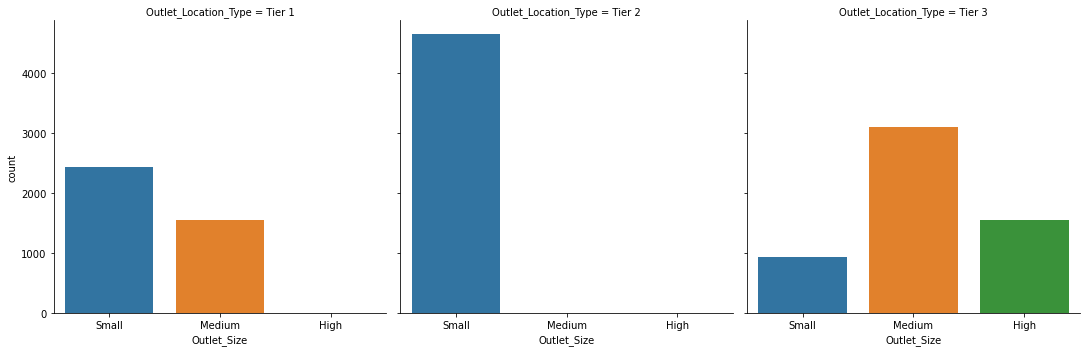

In [42]:
# CHECHING RELATION BETWEEN OUTLET SIZE WITH OUTLET LOCATION TYPE

plt.figure(figsize=(5,3))
sns.catplot('Outlet_Size',col='Outlet_Location_Type',
            kind='count',col_order=['Tier 1','Tier 2','Tier 3'],
            order=['Small','Medium','High'],data=sales)
plt.show()

### Fill missing values in item weight with mean of their corresponding item identifier

In [43]:
sales['Item_Weight']=sales['Item_Weight'].fillna(sales.groupby('Item_Identifier')['Item_Weight'].transform('mean'))

In [44]:
sales.groupby('Item_Identifier')['Item_Weight'].transform('mean')

0         9.30
1         5.92
2        17.50
3        19.20
4         8.93
         ...  
14199    10.50
14200     7.60
14201    10.00
14202    15.30
14203     9.50
Name: Item_Weight, Length: 14204, dtype: float64

In [45]:
sales['Item_Weight'].isna().any()

False

In [46]:
#sales.loc[sales['Item_Type']=='Dairy']['Item_Weight'].mean()

In [47]:
sales.to_csv("modified_sales.csv")
s1=pd.read_csv("modified_sales.csv")
#s1=s1.reset_index()

## **Peprocessing item visibility**
                 Item visibility contains 0 which in real has no meaning. 
                 Item should be visible in Outlet.



In [48]:
sales['Item_Visibility'].replace(0.0,value=np.nan,inplace=True)  # first replace 0 with nan values

In [49]:
# fill nan values with corresponding item identifier mean value
sales['Item_Visibility']=sales['Item_Visibility'].fillna(sales.groupby('Item_Identifier')['Item_Visibility'].transform('mean'))

In [50]:
sales['Item_Weight'].isna().sum()

0

In [51]:
sales.describe().T

,count,mean,std,min,25%,50%,75%,max
Item_Weight,14204.0,12.793380,4.651716,4.555000,8.710000,12.600000,16.750000,21.350000
Item_Visibility,14204.0,0.070458,0.050086,0.003575,0.031381,0.058064,0.098042,0.328391
Item_MRP,14204.0,141.004977,62.086938,31.290000,94.012000,142.247000,185.855600,266.888400
Outlet_Establishment_Year,14204.0,1997.830681,8.371664,1985.000000,1987.000000,1999.000000,2004.000000,2009.000000
Item_Outlet_Sales,8523.0,2181.288914,1706.499616,33.290000,834.247400,1794.331000,3101.296400,13086.964800


### **Feature Engineering**

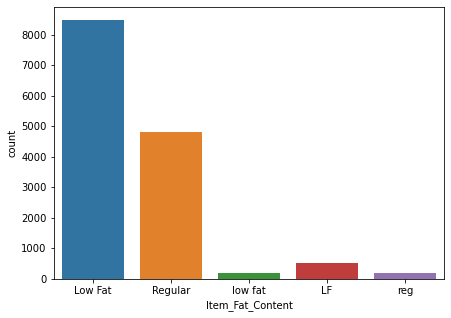

In [52]:
plt.figure(figsize=(7,5))
sns.countplot('Item_Fat_Content',data=sales)

LF, low fat, Low Fat are same value and reg, Regular is another same type

In [53]:
sales['Item_Fat_Content'].replace({'LF':'Low Fat','reg':'Regular','low fat':'Low Fat'},inplace=True)

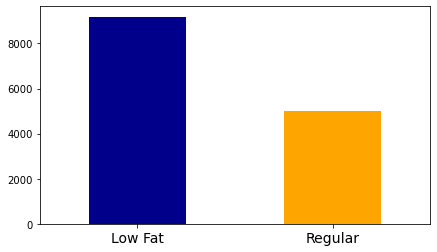

In [54]:
sales['Item_Fat_Content'].value_counts().plot(kind='bar',figsize=(7,4),color=['darkblue','orange'])
plt.xticks(rotation=0,horizontalalignment='center',fontsize=14)
plt.show()

In [55]:
sales['Outlet_Years']=2020-sales['Outlet_Establishment_Year']
sales['Outlet_Years'].value_counts()

35    2439
33    1553
23    1550
21    1550
16    1550
18    1548
11    1546
13    1543
22     925
Name: Outlet_Years, dtype: int64

In [56]:
sales['Item_Identifier']=sales['Item_Identifier'].str[0:2]
sales['Item_Identifier'].value_counts()

FD    10201
NC     2686
DR     1317
Name: Item_Identifier, dtype: int64

In [57]:
sales['Item_Identifier']=sales['Item_Identifier'].replace({'FD':'Food','DR':'Drinks','NC':'Non-Consumable'})
sales['Item_Identifier'].unique()

array(['Food', 'Drinks', 'Non-Consumable'], dtype=object)

In [58]:
# mark non consumable as separate category in low fat
sales.loc[sales['Item_Identifier']=='Non-Consumable','Item_Fat_Content']='Non-Edible'

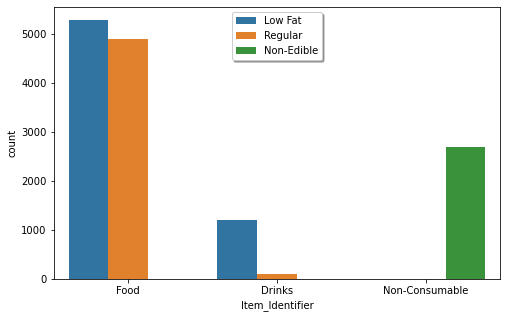

In [59]:
sns.countplot('Item_Identifier',hue="Item_Fat_Content",data=sales)
plt.legend(loc="upper center",shadow=True,fancybox=True)
plt.show()

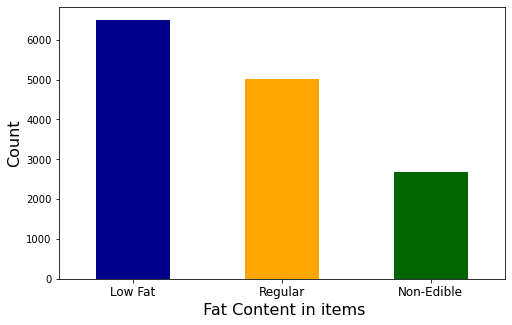

In [60]:
sales['Item_Fat_Content'].value_counts().plot(kind='bar',color=['darkblue','orange','darkgreen'])
plt.xticks(rotation=0,horizontalalignment='center',fontsize=12)
plt.xlabel(" Fat Content in items",fontsize=16)
plt.ylabel("Count",fontsize=16)
plt.show()

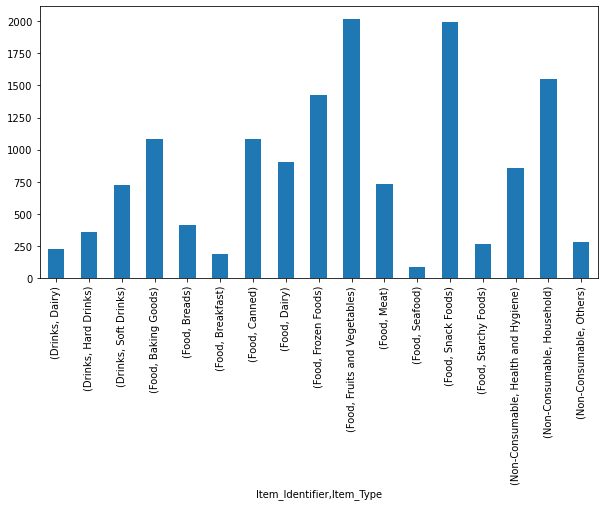

In [61]:
sales.groupby(["Item_Identifier","Item_Type"])['Item_Identifier'].count().plot(kind='bar',figsize=(10,5))

### **Convert categorical columns into numerical values**

> **a.Label Encoding**



In [62]:
# Label encoding for variables which have internal dependency.

var_cat=['Outlet_Size','Outlet_Location_Type','Item_Type','Outlet_Years']
le=LabelEncoder()
for i in var_cat:
  sales[i]=le.fit_transform(sales[i])




> **One Hot Encoding**



In [63]:
#one hot encoding for variables which have no internal dependency
sales=pd.get_dummies(sales,columns=['Item_Identifier','Outlet_Type','Item_Fat_Content','Outlet_Identifier'])

In [64]:
sales.head()

,Item_Weight,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Item_Outlet_Sales,Outlet_Years,Item_Identifier_Drinks,...,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049
0,9.30,0.016047,4,249.8092,1999,1,0,3735.1380,4,0,...,0,0,0,0,0,0,0,0,0,1
1,5.92,0.019278,14,48.2692,2009,1,2,443.4228,0,1,...,0,0,0,1,0,0,0,0,0,0
2,17.50,0.016760,10,141.6180,1999,1,0,2097.2700,4,0,...,0,0,0,0,0,0,0,0,0,1
3,19.20,0.022930,6,182.0950,1998,2,2,732.3800,5,0,...,1,0,0,0,0,0,0,0,0,0
4,8.93,0.014670,9,53.8614,1987,0,2,994.7052,7,0,...,0,1,0,0,0,0,0,0,0,0


In [65]:
sales1=sales.copy()
sales.drop(columns=['Outlet_Establishment_Year',],inplace=True)

**Normalize all columns except Target variable**

In [66]:
scale=MinMaxScaler()
col=list(sales.columns.drop('Item_Outlet_Sales'))
col
sales2=scale.fit_transform(sales)

In [67]:
sales=pd.DataFrame(sales2,columns=sales.columns)
sales["Item_Outlet_Sales"]=sales1['Item_Outlet_Sales']
sales.head()

,Item_Weight,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Item_Outlet_Sales,Outlet_Years,Item_Identifier_Drinks,Item_Identifier_Food,...,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049
0,0.282525,0.038399,0.266667,0.927507,0.5,0.0,3735.1380,0.500,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.081274,0.048346,0.933333,0.072068,0.5,1.0,443.4228,0.000,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.770765,0.040593,0.666667,0.468288,0.5,0.0,2097.2700,0.500,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.871986,0.059588,0.400000,0.640093,1.0,1.0,732.3800,0.625,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.260494,0.034158,0.600000,0.095805,0.0,1.0,994.7052,0.875,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
#Variance
sales[col].var().sort_values(ascending=False)

Item_Fat_Content_Low Fat          0.248215
Item_Fat_Content_Regular          0.228510
Outlet_Type_Supermarket Type1     0.226200
Item_Identifier_Food              0.202413
Outlet_Location_Type              0.165143
Item_Identifier_Non-Consumable    0.153353
Item_Fat_Content_Non-Edible       0.153353
Outlet_Size                       0.116638
Outlet_Years                      0.116472
Outlet_Type_Grocery Store         0.110936
Outlet_Type_Supermarket Type3     0.097718
Outlet_Identifier_OUT027          0.097718
Outlet_Identifier_OUT013          0.097388
Outlet_Identifier_OUT035          0.097223
Outlet_Identifier_OUT049          0.097223
Outlet_Identifier_OUT046          0.097223
Outlet_Identifier_OUT045          0.097113
Outlet_Type_Supermarket Type2     0.097003
Outlet_Identifier_OUT018          0.097003
Outlet_Identifier_OUT017          0.096837
Item_Identifier_Drinks            0.084129
Item_Type                         0.078904
Item_Weight                       0.076713
Item_MRP   

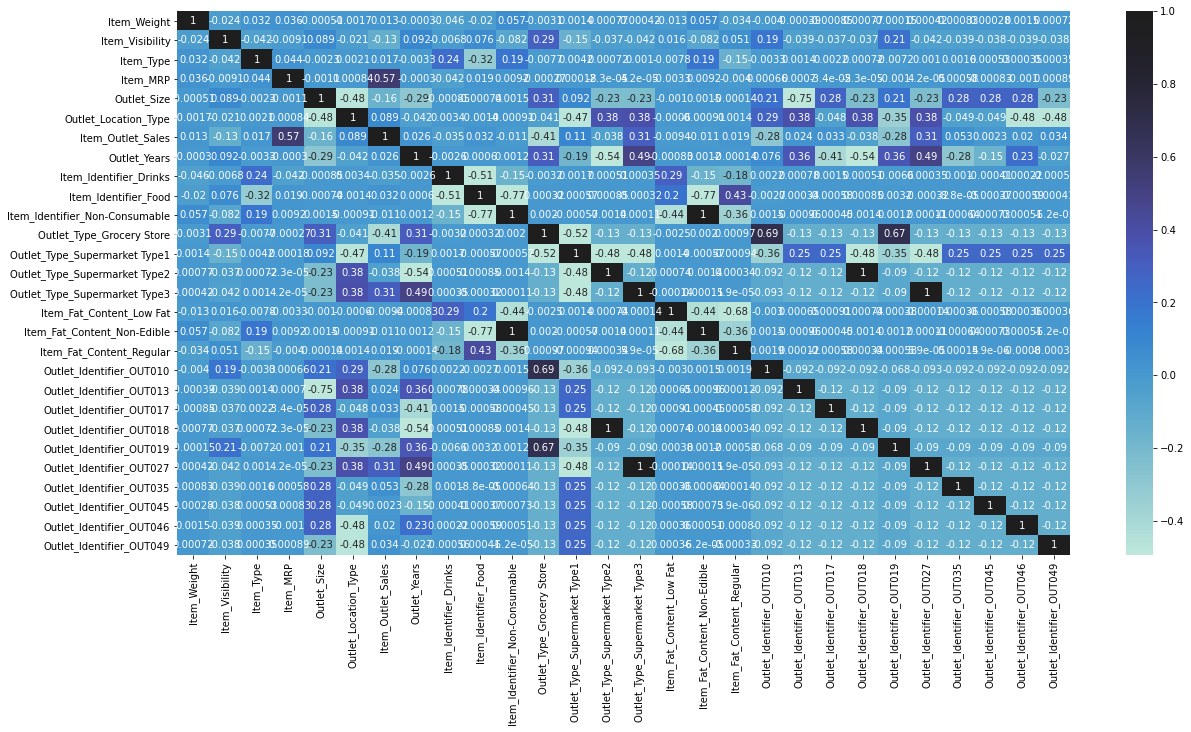

In [69]:
plt.figure(figsize=(20,10))
sns.heatmap(sales.corr(),annot=True,center=True,robust=True)
plt.show()
#checking correlation

In [70]:
sales.columns.drop(['Item_Fat_Content_Non-Edible','Outlet_Identifier_OUT018','Outlet_Identifier_OUT027','Outlet_Identifier_OUT019','Outlet_Identifier_OUT010',])

Index(['Item_Weight', 'Item_Visibility', 'Item_Type', 'Item_MRP',
       'Outlet_Size', 'Outlet_Location_Type', 'Item_Outlet_Sales',
       'Outlet_Years', 'Item_Identifier_Drinks', 'Item_Identifier_Food',
       'Item_Identifier_Non-Consumable', 'Outlet_Type_Grocery Store',
       'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2',
       'Outlet_Type_Supermarket Type3', 'Item_Fat_Content_Low Fat',
       'Item_Fat_Content_Regular', 'Outlet_Identifier_OUT013',
       'Outlet_Identifier_OUT017', 'Outlet_Identifier_OUT035',
       'Outlet_Identifier_OUT045', 'Outlet_Identifier_OUT046',
       'Outlet_Identifier_OUT049'],
      dtype='object')

### After all, Splitting the train and test datasets into their original form as they were before

In [71]:
sales_train=sales.iloc[:8523,:]
sales_test=sales.iloc[8523:,:]
sales_test.drop(columns=['Item_Outlet_Sales'],inplace=True)
sales_train.shape,sales_test.shape

((8523, 28), (5681, 27))

the following list are the features

In [72]:
#features=['Item_Fat_Content','Outlet_Location_Type','Outlet_Years','Outlet_Size','Item_Identifier','Item_MRP','Item_Type','Item_Visibility','Outlet_Type']
features=['Item_Visibility', 'Item_Type', 'Item_MRP',
       'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Years', 'Item_Identifier_Drinks', 'Item_Identifier_Food',
       'Item_Identifier_Non-Consumable', 'Outlet_Type_Grocery Store',
       'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2',
       'Outlet_Type_Supermarket Type3', 'Item_Fat_Content_Low Fat',
       'Item_Fat_Content_Regular', 'Outlet_Identifier_OUT013',
       'Outlet_Identifier_OUT017', 'Outlet_Identifier_OUT035',
       'Outlet_Identifier_OUT045', 'Outlet_Identifier_OUT046',
       'Outlet_Identifier_OUT049']

In [73]:
X=sales_train[features]
y=sales_train['Item_Outlet_Sales']
X_test_sales=sales_test[features]

In [74]:
X_train,X_val,y_train,y_val=train_test_split(X,y,random_state=42,test_size=0.20)
X_train.shape,X_val.shape,y_val.shape

((6818, 21), (1705, 21), (1705,))

## **Model Building**

In [75]:
# defining a function which calculates details of each algorithm
def model_details(model,alg):
    y_pred=model.predict(X_val)
    rmse=np.sqrt(mse(y_val,y_pred))
    acc=round(model.score(X_val,y_val)*100,2)
    cvs=cross_val_score(model,X_val,y_val,cv=5)
    mean=round(cvs.mean()*100,2)
    std=round(cvs.std()*2,2)
    print("Model Report")
    print('Accuracy of {}: {}%'.format(alg,acc),)
    print('RMSE Value: ',round(rmse,2))
    print('Cross Validation Score: Mean - {} | Std - {}'.format(mean,std))

## **Linear Regression**

In [76]:
reg=LinearRegression(normalize=True)

In [77]:
reg.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [78]:
model_details(reg,'LinearRegression')

Model Report
Accuracy of LinearRegression: 58.05%
RMSE Value:  1067.84
Cross Validation Score: Mean - 57.36 | Std - 0.07


In [79]:
ypred=reg.predict(X_val)
y_val,ypred[:6]

(7503    1743.0644
 2957     356.8688
 7031     377.5086
 1084    5778.4782
 856     2356.9320
           ...    
 7205    3004.0896
 3257     890.8404
 6346     629.1810
 6318     253.0040
 6339     976.7286
 Name: Item_Outlet_Sales, Length: 1705, dtype: float64,
 array([1360.,  624.,  864., 4144., 3376.,  640.]))

## **Decision Tree Algorithm**

In [80]:
from sklearn.tree import DecisionTreeRegressor
dtr=DecisionTreeRegressor(max_depth=15,min_samples_leaf=100,min_samples_split=5)

In [81]:
dtr.fit(X_train,y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=15,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=100, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [82]:
model_details(dtr,'DecisionTreeRegressor')

Model Report
Accuracy of DecisionTreeRegressor: 60.76%
RMSE Value:  1032.68
Cross Validation Score: Mean - 38.99 | Std - 0.04


In [83]:
np.argsort(dtr.feature_importances_)

array([10, 18, 17, 16, 15, 13, 12, 11, 19, 20,  8,  6,  3,  7,  0,  4, 14,
        1,  5,  9,  2])

In [84]:
y_test_dtr=y_dtr=dtr.predict(sales_test[features])
y_test_dtr[:5]

array([1694.26737449, 1389.70778307,  586.35411831, 2573.96464182,
       6224.424382  ])

## **Random Forest Regressor**

In [85]:
from sklearn.ensemble import RandomForestRegressor

In [86]:
rf=RandomForestRegressor(n_estimators=200,min_samples_split=7,random_state=42,
                         max_depth=15)
# rf --> random forest

In [87]:
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=7, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [88]:
model_details(rf,'RandomForestRegressor')

Model Report
Accuracy of RandomForestRegressor: 59.49%
RMSE Value:  1049.35
Cross Validation Score: Mean - 56.67 | Std - 0.11


## **XGBoost Regressor**

In [89]:
import xgboost as xgb

In [90]:
dmat=xgb.DMatrix(data=sales_train[features],label=sales_train['Item_Outlet_Sales'])

In [91]:
xg_reg=xgb.XGBRegressor(colsample_bytree=0.3,learning_rate=0.1,max_depth=5,n_estimators=100,reg_alpha=0.75,reg_lambda=0.45,subsample=0.6,seed=42)

In [92]:
xg_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0.75,
             reg_lambda=0.45, scale_pos_weight=1, seed=42, subsample=0.6,
             tree_method=None, validate_parameters=False, verbosity=None)

In [93]:
model_details(xg_reg,'XGBoost')

Model Report
Accuracy of XGBoost: 61.14%
RMSE Value:  1027.68
Cross Validation Score: Mean - 55.32 | Std - 0.08


In [94]:
y=xg_reg.predict(sales_test[features])
y[:10]

array([1658.9504, 1470.786 ,  927.8334, 2736.0193, 5999.427 , 1918.866 ,
        569.1176, 2405.5413, 1522.0623, 2977.0706], dtype=float32)

## **Submission**

In [95]:
sub=pd.read_csv("../input/big-mart-sales-prediction/Submission.csv")

test_sales_pred=rf.predict(sales_test[features])

sub['Item_Outlet_Sales']=y
sub.head(10)

,Unnamed: 0,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,0,FDW58,OUT049,1658.950439
1,1,FDW14,OUT017,1470.786011
2,2,NCN55,OUT010,927.833374
3,3,FDQ58,OUT017,2736.019287
4,4,FDY38,OUT027,5999.426758
5,5,FDH56,OUT046,1918.865967
6,6,FDL48,OUT018,569.117615
7,7,FDC48,OUT027,2405.541260
8,8,FDN33,OUT045,1522.062256
9,9,FDA36,OUT017,2977.070557


In [96]:
sub.to_csv("My_submission.csv")

In [97]:
#prediction of item sales on train dataset
y_test_xgb=xg_reg.predict(X_val)

In [98]:
pred_rf=pd.DataFrame(y_test_xgb,columns=['predicted_rf'])
true_values=list(y_val.values)
pred_rf['true_value']=true_values

In [99]:
# comparision between true and predicted value
comp=pred_rf
comp=comp.iloc[:15]
true_value=comp['true_value']
predicted_value=comp['predicted_rf']

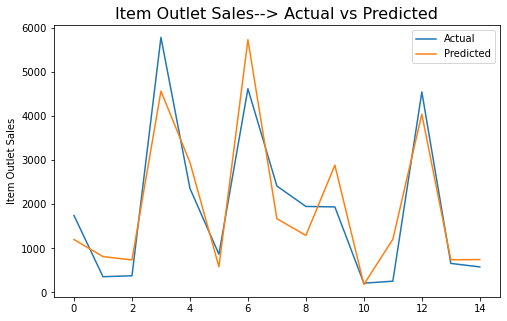

In [100]:
plt.plot(true_value)
plt.plot(predicted_value)
plt.ylabel('Item Outlet Sales')
plt.legend(['Actual','Predicted'])
plt.title("Item Outlet Sales--> Actual vs Predicted",fontsize=16)
plt.show()